In [1]:
import os
import numpy as np
import cPickle
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import timeit
import sklearn
import cv2
import sys
import glob
sys.path.append('./recognition')
from embedding import Embedding
from menpo.visualize import print_progress
from menpo.visualize.viewmatplotlib import sample_colours_from_colourmap
from prettytable import PrettyTable
from pathlib import Path
import warnings 
warnings.filterwarnings("ignore")  

/home/jd4615/miniconda3/envs/insightface/lib/python2.7/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [2]:
def read_template_media_list(path):
    ijb_meta = np.loadtxt(path, dtype=str)
    templates = ijb_meta[:,1].astype(np.int)
    medias = ijb_meta[:,2].astype(np.int)
    return templates, medias

In [3]:
def read_template_pair_list(path):
    pairs = np.loadtxt(path, dtype=str)
    t1 = pairs[:,0].astype(np.int)
    t2 = pairs[:,1].astype(np.int)
    label = pairs[:,2].astype(np.int)
    return t1, t2, label

In [4]:
def read_image_feature(path):
    with open(path, 'rb') as fid:
        img_feats = cPickle.load(fid)
    return img_feats

In [5]:
def get_image_feature(img_path, img_list_path, model_path, gpu_id):
    img_list = open(img_list_path)
    embedding = Embedding(model_path, 0, gpu_id)
    files = img_list.readlines()
    img_feats = []
    faceness_scores = []
    for img_index, each_line in enumerate(print_progress(files)):
        name_lmk_score = each_line.strip().split(' ')
        img_name = os.path.join(img_path, name_lmk_score[0])
        img = cv2.imread(img_name)
        lmk = np.array([float(x) for x in name_lmk_score[1:-1]], dtype=np.float32)
        lmk = lmk.reshape( (5,2) )
        img_feats.append(embedding.get(img,lmk))
        faceness_scores.append(name_lmk_score[-1])
    img_feats = np.array(img_feats).astype(np.float32)
    faceness_scores = np.array(faceness_scores).astype(np.float32)
    return img_feats, faceness_scores

In [6]:
def image2template_feature(img_feats = None, templates = None, medias = None):
    # ==========================================================
    # 1. face image feature l2 normalization. img_feats:[number_image x feats_dim]
    # 2. compute media feature.
    # 3. compute template feature.
    # ==========================================================    
    unique_templates = np.unique(templates)
    template_feats = np.zeros((len(unique_templates), img_feats.shape[1]))

    for count_template, uqt in enumerate(unique_templates):
        (ind_t,) = np.where(templates == uqt)
        face_norm_feats = img_feats[ind_t]
        face_medias = medias[ind_t]
        unique_medias, unique_media_counts = np.unique(face_medias, return_counts=True)
        media_norm_feats = []
        for u,ct in zip(unique_medias, unique_media_counts):
            (ind_m,) = np.where(face_medias == u)
            if ct == 1:
                media_norm_feats += [face_norm_feats[ind_m]]
            else: # image features from the same video will be aggregated into one feature
                media_norm_feats += [np.mean(face_norm_feats[ind_m], 0, keepdims=True)]
        media_norm_feats = np.array(media_norm_feats)
        # media_norm_feats = media_norm_feats / np.sqrt(np.sum(media_norm_feats ** 2, -1, keepdims=True))
        template_feats[count_template] = np.sum(media_norm_feats, 0)
        if count_template % 2000 == 0: 
            print('Finish Calculating {} template features.'.format(count_template))
    template_norm_feats = template_feats / np.sqrt(np.sum(template_feats ** 2, -1, keepdims=True))
    return template_norm_feats, unique_templates

In [19]:
def verification(template_norm_feats = None, unique_templates = None, p1 = None, p2 = None):
    # ==========================================================
    #         Compute set-to-set Similarity Score.
    # ==========================================================
    template2id = np.zeros((max(unique_templates)+1,1),dtype=int)
    for count_template, uqt in enumerate(unique_templates):
        template2id[uqt] = count_template
    
    score = np.zeros((len(p1),))   # save cosine distance between pairs 

    total_pairs = np.array(range(len(p1)))
    batchsize = 100000 # small batchsize instead of all pairs in one batch due to the memory limiation
    sublists = [total_pairs[i:i + batchsize] for i in range(0, len(p1), batchsize)]
    total_sublists = len(sublists)
    for c, s in enumerate(sublists):
        feat1 = template_norm_feats[template2id[p1[s]]]
        feat2 = template_norm_feats[template2id[p2[s]]]
        similarity_score = np.sum(feat1 * feat2, -1)
        score[s] = similarity_score.flatten()
        if c % 10 == 0:
            print('Finish {}/{} pairs.'.format(c, total_sublists))
    return score

In [8]:
def read_score(path):
    with open(path, 'rb') as fid:
        img_feats = cPickle.load(fid)
    return img_feats

# Step1: Load Meta Data

In [9]:
# =============================================================
# load image and template relationships for template feature embedding
# tid --> template id,  mid --> media id 
# format:
#           image_name tid mid
# =============================================================
start = timeit.default_timer()
templates, medias = read_template_media_list(os.path.join('IJBC/meta', 'ijbc_face_tid_mid.txt'))
stop = timeit.default_timer()
print('Time: %.2f s. ' % (stop - start))

Time: 1.73 s. 


In [10]:
# =============================================================
# load template pairs for template-to-template verification
# tid : template id,  label : 1/0
# format:
#           tid_1 tid_2 label
# =============================================================
start = timeit.default_timer()
p1, p2, label = read_template_pair_list(os.path.join('IJBC/meta', 'ijbc_template_pair_label.txt'))
stop = timeit.default_timer()
print('Time: %.2f s. ' % (stop - start))

Time: 63.98 s. 


# Step 2: Get Image Features

In [12]:
# =============================================================
# load image features 
# format:
#           img_feats: [image_num x feats_dim] (227630, 512)
# =============================================================
start = timeit.default_timer()
#img_feats = read_image_feature('./MS1MV2/IJBB_MS1MV2_r100_arcface.pkl')
img_path = './IJBC/loose_crop'
img_list_path = './IJBC/meta/ijbc_name_5pts_score.txt'
model_path = './pretrained_models/MS1MV2-ResNet100-Arcface/model'
gpu_id = 1
img_feats, faceness_scores = get_image_feature(img_path, img_list_path, model_path, gpu_id)
stop = timeit.default_timer()
print('Time: %.2f s. ' % (stop - start))
print('Feature Shape: ({} , {}) .'.format(img_feats.shape[0], img_feats.shape[1]))

('loading', './pretrained_models/MS1MV2-ResNet100-Arcface/model', 0)
[====================] 100% (469375/469375) - done.                             
Time: 6806.24 s. 
Feature Shape: (469375 , 1024) .


# Step3: Get Template Features

In [34]:
# =============================================================
# compute template features from image features.
# =============================================================
start = timeit.default_timer()
# ========================================================== 
# Norm feature before aggregation into template feature?
# Feature norm from embedding network and faceness score are able to decrease weights for noise samples (not face).
# ========================================================== 
# 1. FaceScore （Feature Norm）
# 2. FaceScore （Detector）

use_norm_score = False # if Ture, TestMode(N1)  
use_detector_score = False # if Ture, TestMode(D1)
use_flip_test = False # if Ture, TestMode(F1)

if use_flip_test:
    # concat --- F1
    #img_input_feats = img_feats 
    # add --- F2
    img_input_feats = img_feats[:,0:img_feats.shape[1]/2] + img_feats[:,img_feats.shape[1]/2:]
else:
    img_input_feats = img_feats[:,0:img_feats.shape[1]/2]
    
if use_norm_score:
    img_input_feats = img_input_feats
else:
    # normalise features to remove norm information
    img_input_feats = img_input_feats / np.sqrt(np.sum(img_input_feats ** 2, -1, keepdims=True))    
    
if use_detector_score:
    img_input_feats = img_input_feats * np.matlib.repmat(faceness_scores[:,np.newaxis], 1, img_input_feats.shape[1])
else:
    img_input_feats = img_input_feats

template_norm_feats, unique_templates = image2template_feature(img_input_feats, templates, medias)
stop = timeit.default_timer()
print('Time: %.2f s. ' % (stop - start))

Finish Calculating 0 template features.
Finish Calculating 2000 template features.
Finish Calculating 4000 template features.
Finish Calculating 6000 template features.
Finish Calculating 8000 template features.
Finish Calculating 10000 template features.
Finish Calculating 12000 template features.
Finish Calculating 14000 template features.
Finish Calculating 16000 template features.
Finish Calculating 18000 template features.
Finish Calculating 20000 template features.
Finish Calculating 22000 template features.
Time: 7.85 s. 


# Step 4: Get Template Similarity Scores

In [35]:
# =============================================================
# compute verification scores between template pairs.
# =============================================================
start = timeit.default_timer()
score = verification(template_norm_feats, unique_templates, p1, p2)
stop = timeit.default_timer()
print('Time: %.2f s. ' % (stop - start))

Finish 0/157 pairs.
Finish 10/157 pairs.
Finish 20/157 pairs.
Finish 30/157 pairs.
Finish 40/157 pairs.
Finish 50/157 pairs.
Finish 60/157 pairs.
Finish 70/157 pairs.
Finish 80/157 pairs.
Finish 90/157 pairs.
Finish 100/157 pairs.
Finish 110/157 pairs.
Finish 120/157 pairs.
Finish 130/157 pairs.
Finish 140/157 pairs.
Finish 150/157 pairs.
Time: 67.17 s. 


In [36]:
score_save_name = './IJBC/result/MS1MV2-ResNet100-ArcFace-TestMode(N0D0F0).npy'
np.save(score_save_name, score)

# Step 5: Get ROC Curves and TPR@FPR Table

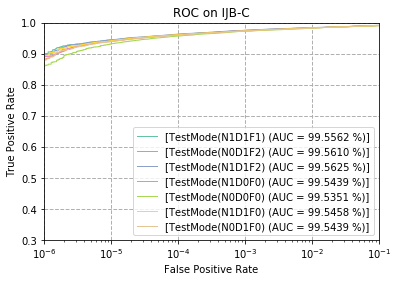

In [38]:
score_save_path = './IJBC/result'
files = glob.glob(score_save_path + '/MS1MV2*.npy')  
methods = []
scores = []
for file in files:
    methods.append(Path(file).stem)
    scores.append(np.load(file)) 
methods = np.array(methods)
scores = dict(zip(methods,scores))
colours = dict(zip(methods, sample_colours_from_colourmap(methods.shape[0], 'Set2')))
#x_labels = [1/(10**x) for x in np.linspace(6, 0, 6)]
x_labels = [10**-6, 10**-5, 10**-4,10**-3, 10**-2, 10**-1]
tpr_fpr_table = PrettyTable(['Methods'] + map(str, x_labels))
fig = plt.figure()
for method in methods:
    fpr, tpr, _ = roc_curve(label, scores[method])
    roc_auc = auc(fpr, tpr)
    fpr = np.flipud(fpr)
    tpr = np.flipud(tpr) # select largest tpr at same fpr
    plt.plot(fpr, tpr, color=colours[method], lw=1, label=('[%s (AUC = %0.4f %%)]' % (method.split('-')[-1], roc_auc*100)))
    tpr_fpr_row = []
    tpr_fpr_row.append(method)
    for fpr_iter in np.arange(len(x_labels)):
        _, min_index = min(list(zip(abs(fpr-x_labels[fpr_iter]), range(len(fpr)))))
        tpr_fpr_row.append('%.4f' % tpr[min_index])
    tpr_fpr_table.add_row(tpr_fpr_row)
plt.xlim([10**-6, 0.1])
plt.ylim([0.3, 1.0])
plt.grid(linestyle='--', linewidth=1)
plt.xticks(x_labels) 
plt.yticks(np.linspace(0.3, 1.0, 8, endpoint=True)) 
plt.xscale('log')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC on IJB-C')
plt.legend(loc="lower right")
plt.show()
#fig.savefig('IJB-B.pdf')

In [39]:
print(tpr_fpr_table)

+-------------------------------------------+--------+--------+--------+--------+--------+--------+
|                  Methods                  | 1e-06  | 1e-05  | 0.0001 | 0.001  |  0.01  |  0.1   |
+-------------------------------------------+--------+--------+--------+--------+--------+--------+
| MS1MV2-ResNet100-ArcFace-TestMode(N1D1F1) | 0.8997 | 0.9434 | 0.9618 | 0.9744 | 0.9832 | 0.9907 |
| MS1MV2-ResNet100-ArcFace-TestMode(N0D1F2) | 0.8829 | 0.9400 | 0.9607 | 0.9746 | 0.9833 | 0.9910 |
| MS1MV2-ResNet100-ArcFace-TestMode(N1D1F2) | 0.8985 | 0.9447 | 0.9628 | 0.9753 | 0.9836 | 0.9908 |
| MS1MV2-ResNet100-ArcFace-TestMode(N1D0F0) | 0.8906 | 0.9394 | 0.9603 | 0.9731 | 0.9829 | 0.9904 |
| MS1MV2-ResNet100-ArcFace-TestMode(N0D0F0) | 0.8625 | 0.9315 | 0.9565 | 0.9720 | 0.9818 | 0.9901 |
| MS1MV2-ResNet100-ArcFace-TestMode(N1D1F0) | 0.8943 | 0.9413 | 0.9610 | 0.9735 | 0.9829 | 0.9905 |
| MS1MV2-ResNet100-ArcFace-TestMode(N0D1F0) | 0.8795 | 0.9387 | 0.9591 | 0.9731 | 0.9824 | 0.9904 |


In [ ]:
# setting N1D1F2 is the best